In [1]:
from my import source as my
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 避免频繁刷新jupyter造成卡顿
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 使用的是加州房价数据集
column_names = ['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']
df = my.pd.read_csv(r'D:\pycharmProject\my_package\my\data\cal_housing.csv', names=column_names)
df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [4]:
# 使用my的ViewDataframe类查看数据
viewer = my.ViewDataframe(df=df)
viewer.display_info()


--- 数据维度 ---
维度: 20640 行 x 9 列

--- 特征类型 ---
                     数据类型
longitude         float64
latitude          float64
housingMedianAge  float64
totalRooms        float64
totalBedrooms     float64
population        float64
households        float64
medianIncome      float64
medianHouseValue  float64

--- 缺失值信息 ---
                  缺失值统计 缺失值占比 (%)
longitude             0     0.00%
latitude              0     0.00%
housingMedianAge      0     0.00%
totalRooms            0     0.00%
totalBedrooms         0     0.00%
population            0     0.00%
households            0     0.00%
medianIncome          0     0.00%
medianHouseValue      0     0.00%

--- 重复值信息 ---
重复行统计        0
重复行占比    0.00%
dtype: object

--- 数据展示(前五行+后五行) ---
       longitude  latitude  housingMedianAge  totalRooms  totalBedrooms  \
0        -122.23     37.88              41.0       880.0          129.0   
1        -122.22     37.86              21.0      7099.0         1106.0   
2        -122.24     37.85      

In [ ]:
# 所有变量中去除经纬度(单独分析)和响应变量
num_var = list(df.iloc[:, 2:].columns.values)
# 采用my包的增强型统计描述
my.describe_plus(df[num_var])

In [ ]:
'''
绘制变量分布图不难发现，多数变量呈现右侧拖尾的结构
房龄和房价比较特殊，在房龄和房价很高的地方count值也很大
'''
plot = my.DataVisualization(df, num_var=num_var)
plot.histogram_plot(color='gold', figsize=(12,4))

In [ ]:
# medianIncome和房价有明显的线性关系，并且斜率应该很高，说明相关性很高
plot.join_plot(dependent_variable='medianHouseValue', kind='hex',color='yellow')

In [ ]:
# 部分变量存在异常值，整体还好
plot.box_plot(color='orangered')

In [ ]:
plot.heatmaps(var_list=num_var+['medianHouseValue'],cmap='copper')

In [ ]:
# 经纬度分析
# 房价和位置关系还是很明晰的，有的地方颜色明显更深
df.plot(kind='scatter', x='longitude',  y='latitude', alpha=0.3,
        c='medianHouseValue', cmap='Reds',
        colorbar=True, figsize=(8,6))
my.plt.grid()

In [4]:
# 这里不做特征工程和其他数据处理工作,仅用作示例，模型效果可能很一般
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_trainval, X_test, y_trainval, y_test = my.cut_data(X, y)
baseline_model = RandomForestRegressor(random_state=123, n_jobs=-1)
my.train_regression_baseline(baseline_model, X_trainval, y_trainval, is_print=True,
                             eval_metrics=[my.root_mean_squared_error])

运行时间16.793941497802734秒
模型结果:
        R2_score           MSE  root_mean_squared_error
train  0.973110  3.602394e+08             18979.683898
val    0.809437  2.549134e+09             50463.568927


In [5]:
# 也可以自定义计算多个评价指标
my.train_regression_baseline(baseline_model, X_trainval, y_trainval, is_print=True,
                             eval_metrics=[my.root_mean_squared_error, mean_absolute_error])

运行时间16.740073680877686秒
模型结果:
        R2_score           MSE  root_mean_squared_error  mean_absolute_error
train  0.973110  3.602394e+08             18979.683898         12288.874028
val    0.809437  2.549134e+09             50463.568927         32873.110007


In [6]:
# 做一个简单的调参
params = {'n_estimators': ['int', 100, 500], 'max_features': ['int', 1, 4], 'random_state': 123, 'n_jobs': -1}
optuna_frame = my.OptunaForGeneralML(X_trainval, y_trainval, task_type='regression', params=params, ml_method='sklearn.ensemble.RandomForestRegressor', scoring=my.root_mean_squared_error.__name__)
best_params, best_value = optuna_frame.optimize(n_trials=30, direction='minimize', eval_metrics=[my.root_mean_squared_error])
print(best_params, best_value)

[I 2024-04-27 21:52:30,178] A new study created in memory with name: no-name-01845afc-e794-4c21-bd3d-53aec0ddd491
[I 2024-04-27 21:55:31,224] Trial 10 finished with value: 50292.39047158289 and parameters: {'n_estimators': 161, 'max_features': 3}. Best is trial 10 with value: 50292.39047158289.
[I 2024-04-27 21:55:57,716] Trial 3 finished with value: 49335.2029232511 and parameters: {'n_estimators': 206, 'max_features': 4}. Best is trial 3 with value: 49335.2029232511.
[I 2024-04-27 21:56:03,433] Trial 11 finished with value: 51752.254399011814 and parameters: {'n_estimators': 248, 'max_features': 2}. Best is trial 3 with value: 49335.2029232511.
[I 2024-04-27 21:56:04,176] Trial 9 finished with value: 51718.79854502411 and parameters: {'n_estimators': 270, 'max_features': 2}. Best is trial 3 with value: 49335.2029232511.
[I 2024-04-27 21:56:31,942] Trial 15 finished with value: 56415.85499093203 and parameters: {'n_estimators': 337, 'max_features': 1}. Best is trial 3 with value: 4933

运行时间: 460.9440076351166秒
{'n_estimators': 372, 'max_features': 4} 49287.942296318455


In [7]:
'''
调参以后验证集略有提升，这里只是一个演示，读者可以自行去做更多的工作，比如减少过拟合、做更多的特征工程、增加调参范围等
并且值得注意的是，加州房价数据集是一个中型大小的数据集，本次调参大概是一万四千条数据做十折交叉验证，用时已经达到460秒
如果采用传统的网格搜索等方法大概率更慢，所以数据集很大的话，建议采用LightGBM等方法或者降低n_splits
'''
params.update(best_params)
model = my.BuildBestModel(X_trainval, y_trainval, X_test, y_test, params, task_type='regression', eval_metrics=[my.root_mean_squared_error, mean_absolute_error], ml_method='sklearn.ensemble.RandomForestRegressor')
model.train()

'\n调参以后验证集略有提升，这里只是一个演示，读者可以自行去做更多的工作，比如减少过拟合、做更多的特征工程、增加调参范围等\n并且值得注意的是，加州房价数据集是一个中型大小的数据集，本次调参大概是一万四千条数据做十折交叉验证，用时已经达到715秒\n如果采用传统的网格搜索等方法大概率更慢，所以数据集很大的话，建议采用LightGBM等方法或者降低n_splits\n'

运行时间23.267374515533447秒
模型结果:
        R2_score           MSE  root_mean_squared_error  mean_absolute_error
train  0.975020  3.346471e+08             18293.227068         12089.528298
val    0.818221  2.431675e+09             49287.942296         32646.913777


In [8]:
effect = model.evaluate()
print(effect)

{'root_mean_squared_error': 49515.57578945568, 'mean_absolute_error': 32609.791072334054}


In [9]:
# 使用lightgbm
# OptunaLGB默认准备一定范围的参数，用户也可以自行更改，这里人为给定参数reg_alpha为0.8
optuna_lgb = my.OptunaForLGB(X_trainval, y_trainval, task_type='regression', stopping_rounds=50, eval_metric=my.root_mean_squared_error)
best_params_lgb, best_value_lgb = optuna_lgb.optimize_lgb(n_trials=30, custom_params={'reg_alpha': 0.8})
print(best_params_lgb)

[I 2024-04-27 22:05:39,887] A new study created in memory with name: no-name-cb9c0b9c-6f65-449f-98eb-d32619806815


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best ite

In [10]:
# lightgbm比随机森林的调参结果要更高一些，并且过拟合更轻，训练速度更快，但是泛化能力没有大幅提高，说明特征工程才是最重要的，调参不是
best_model_lgb = my.lgb.LGBMRegressor(**best_params_lgb)
my.train_regression_baseline(best_model_lgb, X_trainval, y_trainval, eval_metrics=[my.root_mean_squared_error, mean_absolute_error], is_print=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13003, number of used features: 8
[LightGBM] [Info] Start training from score 206275.144659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [11]:
# 采用原始参数作为对比
original_lgb = my.lgb.LGBMRegressor(random_state=123, n_jobs=-1)
my.train_regression_baseline(original_lgb, X_trainval, y_trainval, is_print=True, eval_metrics=[my.root_mean_squared_error, mean_absolute_error])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13003, number of used features: 8
[LightGBM] [Info] Start training from score 206275.144659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13003, number of used features: 8
[LightGBM] [Info] Start training from score 206293.517496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13003, number of used features: 8
[LightGBM] [Info] St

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 1300, number of used features: 8
[LightGBM] [Info] Start training from score 203915.050000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

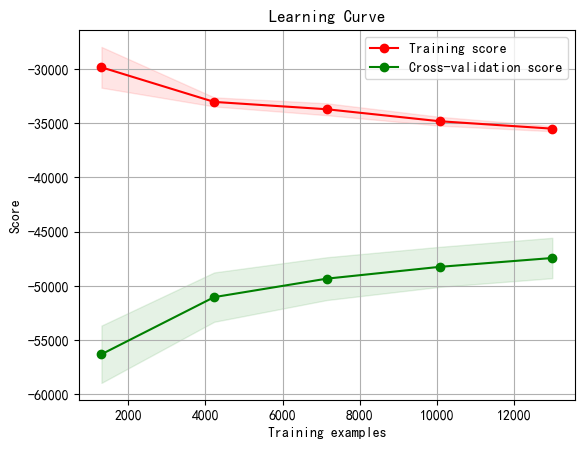

In [12]:
pred = best_model_lgb.predict(X_test)
model_plot = my.PlotForML(y_test, pred, None)
model_plot.learning_curve(best_model_lgb, X_trainval, y_trainval, scoring='neg_root_mean_squared_error')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

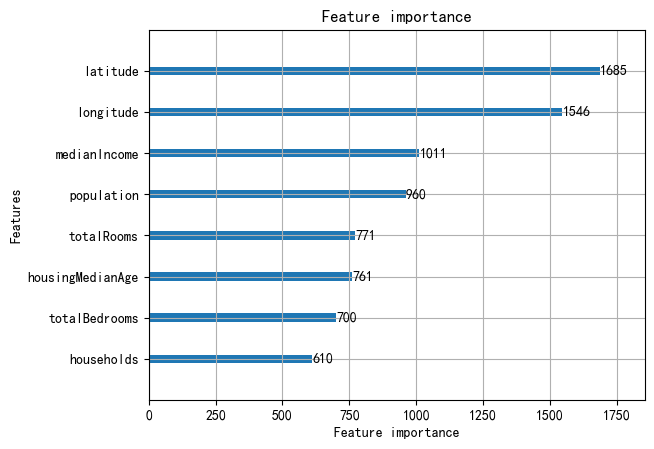

In [13]:
from lightgbm import plot_importance
plot_importance(best_model_lgb)